# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import torch 
import numpy as np
import os

goGPU = torch.cuda.is_available() #Checking if GPU available 

print ('on GPU') if goGPU else print('On CPU')

on GPU


In [4]:
#Data mentioned in the instructions is not available in the workspace. Downloading data from https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip
import requests, zipfile, io

url = 'https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip'
destination_folder = 'data'

if not (os.path.exists(destination_folder)):
    print('Data not available in workspace, downloading...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(destination_folder)
    print('Download complete.')
else:
    print('Data available in workspace')
    

Data not available in workspace, downloading...
Download complete.


In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
from torchvision import transforms, models
from torchsampler import ImbalancedDatasetSampler
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import splitfolders

batch_size = 30
num_workers = 4
#Data location
data_location = 'data/landmark_images/'

#Splitting training data for validation with ration .8 to .2
split = splitfolders.ratio("data/landmark_images/train", output="data/landmark_images/split/", seed=1337, ratio=(.8, .2), group_prefix=None)

train_dataset_location, validation_dataset_location, test_dataset_location = os.path.join(data_location, 'split', 'train'), os.path.join(data_location, 'split', 'val'), os.path.join(data_location, 'test')

#Transforms compose
train_transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5 , 0.5, 0.5))
])

valid_test_transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5 , 0.5, 0.5))
])


train_data = datasets.ImageFolder(train_dataset_location, transform=train_transform)
valid_data = datasets.ImageFolder(validation_dataset_location, transform=valid_test_transform)
test_data = datasets.ImageFolder(test_dataset_location, transform=valid_test_transform)


#Data Loaders

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_data), num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


loaders_scratch = {'train': train_loader, 'valid': validation_loader, 'test': test_loader}

Copying files: 4996 files [00:10, 455.15 files/s]


In [28]:
#Checking how many files in each folder
for root, dirs, files in os.walk('data/landmark_images/split/train'):
    file_count = len(files)
    print(file_count)

0
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
76


In [29]:
print(f'Number of images for training is {len(train_data)}, for validation is {len(valid_data)}, and for testing is {len(test_data)}')
print(f'Total batches for training are {len(train_loader)}, for validation {len(validation_loader)} and for testing {len(test_loader)}')

Number of images for training is 3996, for validation is 1000, and for testing is 1250
Total batches for training are 134, for validation 34 and for testing 42


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

The original pictures are 600x800. The images loaded to the datasets are being resized to 224x224. This selection was done based on what ResNet or VGG expect which is an input of 224 x 224 and it makes sense to follow that path. 

Data Augmentation was applied to the training set as it is meant to get better performance. No Data Augmentation done on the test dataset. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [3]:
classes = [str(x)[3:].replace("_", " ") for x in train_data.classes]
classes

['Haleakala National Park',
 'Mount Rainier National Park',
 'Ljubljana Castle',
 'Dead Sea',
 'Wroclaws Dwarves',
 'London Olympic Stadium',
 'Niagara Falls',
 'Stonehenge',
 'Grand Canyon',
 'Golden Gate Bridge',
 'Edinburgh Castle',
 'Mount Rushmore National Memorial',
 'Kantanagar Temple',
 'Yellowstone National Park',
 'Terminal Tower',
 'Central Park',
 'Eiffel Tower',
 'Changdeokgung',
 'Delicate Arch',
 'Vienna City Hall',
 'Matterhorn',
 'Taj Mahal',
 'Moscow Raceway',
 'Externsteine',
 'Soreq Cave',
 'Banff National Park',
 'Pont du Gard',
 'Seattle Japanese Garden',
 'Sydney Harbour Bridge',
 'Petronas Towers',
 'Brooklyn Bridge',
 'Washington Monument',
 'Hanging Temple',
 'Sydney Opera House',
 'Great Barrier Reef',
 'Monumento a la Revolucion',
 'Badlands National Park',
 'Atomium',
 'Forth Bridge',
 'Gateway of India',
 'Stockholm City Hall',
 'Machu Picchu',
 'Death Valley National Park',
 'Gullfoss Falls',
 'Trevi Fountain',
 'Temple of Heaven',
 'Great Wall of China',

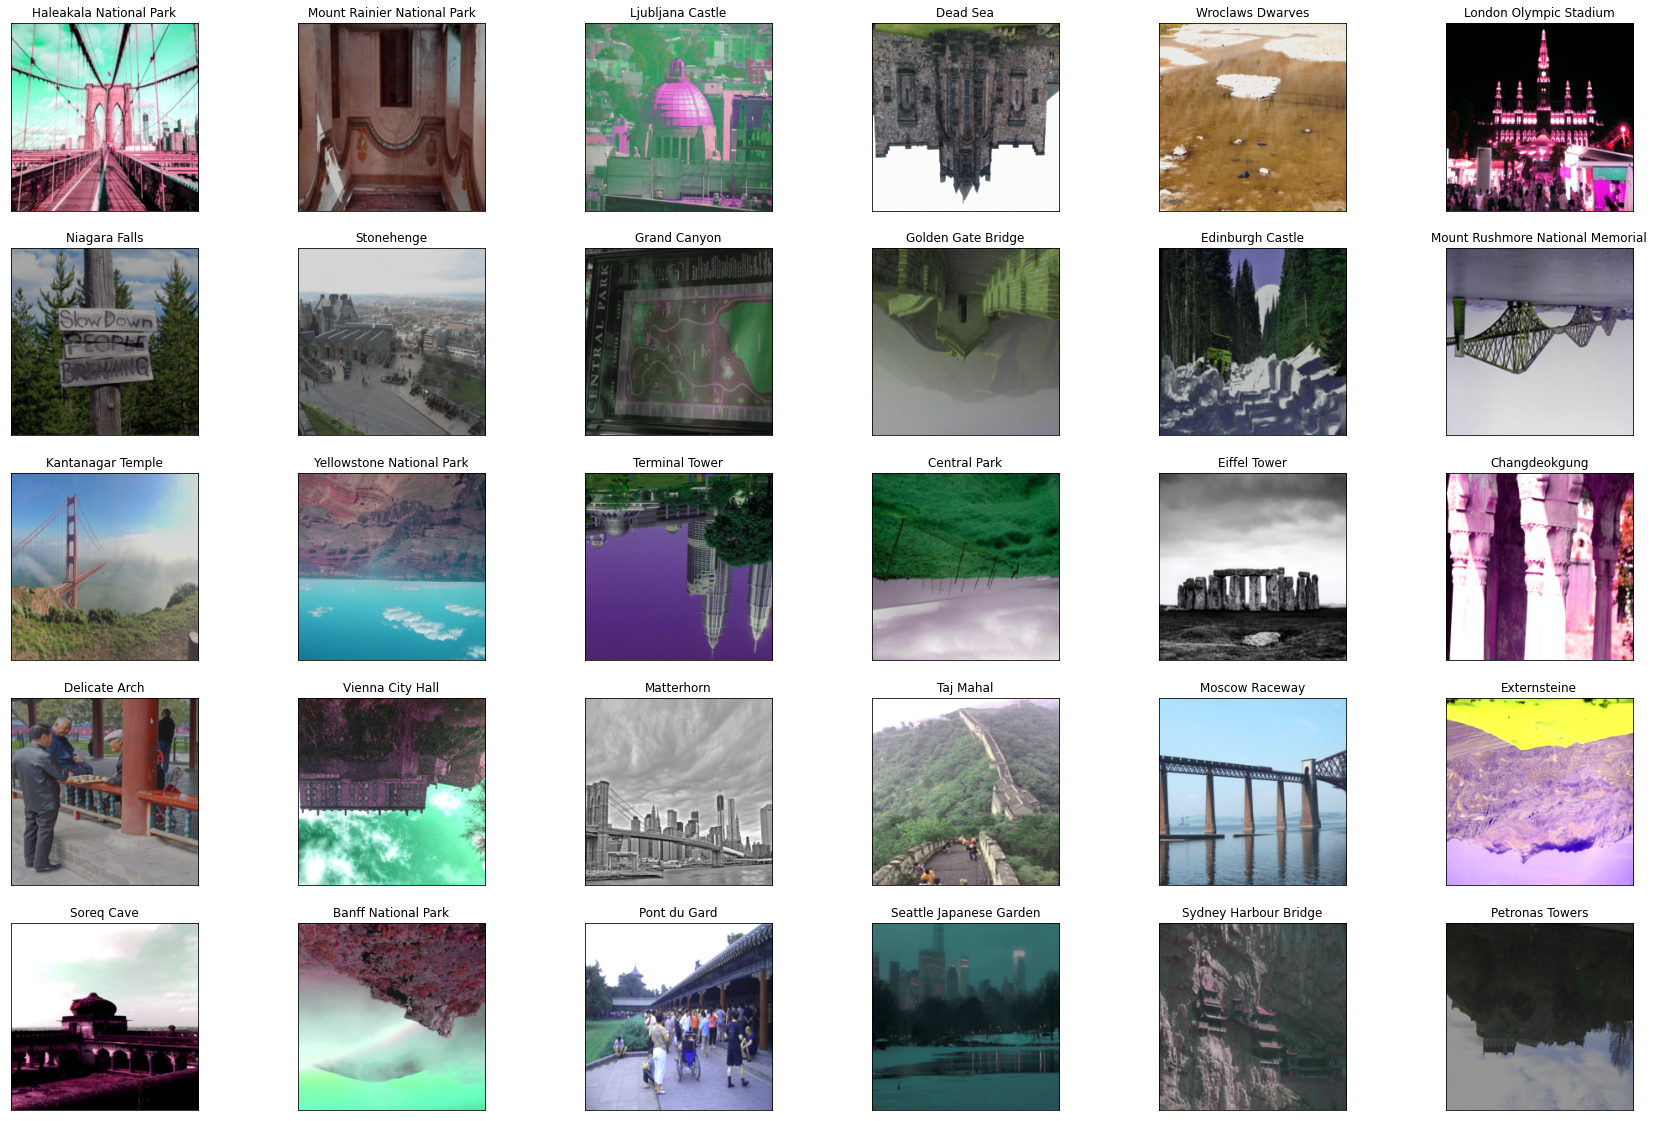

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def show_img(img):
    img = img /2 +0.5
    plt.imshow(np.transpose(img, (1,2,0)))

    
images, labels = next(iter(train_loader))
images = images.numpy()
    
fig = plt.figure(figsize=(30,20))

#Showing first 30 images
for idx, image in enumerate(images[0:30]):
    ax = fig.add_subplot(5,6, idx+1, xticks=[],yticks=[])
    show_img(images[idx])
    ax.set_title(classes[idx], wrap=True)
    




### Initialize use_cuda variable

In [ ]:
# useful variable that tells us whether we should use the GPU
#use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.01)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        #Conv Layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        #Max Pool
        self.maxpool = nn.MaxPool2d(2,2)
        #Dropout
        self.dropout = nn.Dropout(0.25)
        #Linear
        self.fc1 = nn.Linear(64*28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512,len(classes)) #Number of classes
        
        
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        #Flattening
        x = x.view(-1, 64*28*28)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)  
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if goGPU:
    print('Training on GPU')
    model_scratch.cuda()
else:
    print('Training on CPU')

Training on GPU


In [39]:
from torchsummary import summary

summary(model_scratch, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          18,496
         MaxPool2d-6           [-1, 64, 28, 28]               0
           Dropout-7                [-1, 50176]               0
            Linear-8                 [-1, 1024]      51,381,248
           Dropout-9                 [-1, 1024]               0
           Linear-10                  [-1, 512]         524,800
           Linear-11                   [-1, 50]          25,650
Total params: 51,955,282
Trainable params: 51,955,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

Inspired by the lessons in this CNN course, I implemented a Neural Network with 3 Convolutional Layers and after each conv layer, there is Max Pooling that will divide the feature maps by half:

224x224 => 112x112 => 56x56 => 28x28 

Each Conv layer is passed through ReLu Activation function.

The tensor is then flattened and passed to a fully connected layer. Each layer goes through a leaky ReLu which behaves differently than normal ReLU.ReLu returns a value from f(x) = max(0, x) and takes zero value if values are negative. This can lead to dead neurons. With leaky ReLU this does not happen, the function is f(x) = max(0.001x, x). Leaky ReLU should perform better than ReLU.
To avoid overfitting, dropout is applied.


### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 

    print("use_cuda: ",goGPU," -> ", torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('\tAllocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('\tCached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if goGPU:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad() #Clear Gradients 
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
                

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if goGPU:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

            
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(validation_loader)


        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if (valid_loss <= valid_loss_min):
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [40]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    #https://androidkt.com/initialize-weight-bias-pytorch/
    #https://pytorch.org/cppdocs/api/function_namespacetorch_1_1nn_1_1init_1a5e807af188fc8542c487d50d81cb1aa1.html
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='leaky_relu')
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, goGPU, 'ignore.pt')

use_cuda:  True  ->  NVIDIA GeForce RTX 2070 with Max-Q Design
Memory Usage:
	Allocated: 0.5 GB
	Cached:    1.2 GB
Epoch: 1 	Training Loss: 0.029865 	Validation Loss: 0.112563
Validation loss decreased (inf --> 0.112563).  Saving model ...
use_cuda:  True  ->  NVIDIA GeForce RTX 2070 with Max-Q Design
Memory Usage:
	Allocated: 0.5 GB
	Cached:    1.2 GB
Epoch: 2 	Training Loss: 0.028394 	Validation Loss: 0.109593
Validation loss decreased (0.112563 --> 0.109593).  Saving model ...
use_cuda:  True  ->  NVIDIA GeForce RTX 2070 with Max-Q Design
Memory Usage:
	Allocated: 0.5 GB
	Cached:    1.2 GB
Epoch: 3 	Training Loss: 0.027576 	Validation Loss: 0.107268
Validation loss decreased (0.109593 --> 0.107268).  Saving model ...
use_cuda:  True  ->  NVIDIA GeForce RTX 2070 with Max-Q Design
Memory Usage:
	Allocated: 0.5 GB
	Cached:    1.2 GB
Epoch: 4 	Training Loss: 0.026672 	Validation Loss: 0.104225
Validation loss decreased (0.107268 --> 0.104225).  Saving model ...
use_cuda:  True  ->  NVID

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [7]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 40 

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, goGPU, 'model_scratch.pt')

use_cuda:  True  ->  NVIDIA GeForce RTX 2070 with Max-Q Design
Memory Usage:
	Allocated: 0.2 GB
	Cached:    0.2 GB
Epoch: 1 	Training Loss: 0.029192 	Validation Loss: 0.115041
Validation loss decreased (inf --> 0.115041).  Saving model ...
Epoch: 2 	Training Loss: 0.029188 	Validation Loss: 0.115023
Validation loss decreased (0.115041 --> 0.115023).  Saving model ...
Epoch: 3 	Training Loss: 0.029189 	Validation Loss: 0.114996
Validation loss decreased (0.115023 --> 0.114996).  Saving model ...
Epoch: 4 	Training Loss: 0.029176 	Validation Loss: 0.114939
Validation loss decreased (0.114996 --> 0.114939).  Saving model ...
Epoch: 5 	Training Loss: 0.029162 	Validation Loss: 0.114886
Validation loss decreased (0.114939 --> 0.114886).  Saving model ...
Epoch: 6 	Training Loss: 0.029142 	Validation Loss: 0.114740
Validation loss decreased (0.114886 --> 0.114740).  Saving model ...
Epoch: 7 	Training Loss: 0.029074 	Validation Loss: 0.114410
Validation loss decreased (0.114740 --> 0.114410)

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [8]:
def test(loaders, model, criterion, gpGPU):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if goGPU:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [9]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, goGPU)

Test Loss: 3.109859


Test Accuracy: 23% (291/1250)


**Notes**

By running the test on the ignore.pt model which was trained only with 20 epochs, the accuracy was 25%. This could mean that the weight initialization plays an important role in this type of tasks. 
The model trained with default weights, after 25 epochs had higher validation loss. After retraining for 40 epochs, the validation went lower. However the weights initialization was surely speeding up the training while using the defaults ones gave small jumps but constant. 

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [10]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


#Reusing the loaders already set
loaders_transfer = {'train': train_loader, 'valid': validation_loader, 'test': test_loader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [11]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.Adam(model.fc.parameters(), lr=0.001)
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [3]:
torch. __version__

'1.10.2+cu113'

In [12]:
## TODO: Specify model architecture

model_transfer = models.resnet50(pretrained=True)


#-#-# Do NOT modify the code below this line. #-#-#

if goGPU:
    model_transfer = model_transfer.cuda()
    print('Training on GPU')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\ultra/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:12<00:00, 8.22MB/s]


Training on GPU


In [73]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [13]:
for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512,50),
                                 )

if goGPU:
    model_transfer = model_transfer.cuda()

In [21]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

My choice was betwen VGG16 which was trained on millions of images and ResNet which I had used for previous projects and performed well. For this time I tried ResNet50 which may be an overkill but I was curious to see the results. 
I was interested to try out EfficientNet but since it is supported from 0.11v then I did not upgrade pytorch in the workspace. I changed the last fc layer by replacing it with a 2 linear layers.Compared to the previous network, I also decided to go for a different optimizer (Adam instead of SGD).


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [75]:
from workspace_utils import *

In [14]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 50 #Trained first with 20, retrained again with 50

#with active_session():
train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                          criterion_transfer, goGPU, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

use_cuda:  True  ->  NVIDIA GeForce RTX 2070 with Max-Q Design
Memory Usage:
	Allocated: 0.5 GB
	Cached:    1.3 GB
Epoch: 1 	Training Loss: 0.023845 	Validation Loss: 0.067258
Validation loss decreased (inf --> 0.067258).  Saving model ...
Epoch: 2 	Training Loss: 0.016829 	Validation Loss: 0.050165
Validation loss decreased (0.067258 --> 0.050165).  Saving model ...
Epoch: 3 	Training Loss: 0.013740 	Validation Loss: 0.044442
Validation loss decreased (0.050165 --> 0.044442).  Saving model ...
Epoch: 4 	Training Loss: 0.012933 	Validation Loss: 0.039085
Validation loss decreased (0.044442 --> 0.039085).  Saving model ...
Epoch: 5 	Training Loss: 0.011260 	Validation Loss: 0.039016
Validation loss decreased (0.039085 --> 0.039016).  Saving model ...
Epoch: 6 	Training Loss: 0.011194 	Validation Loss: 0.038633
Validation loss decreased (0.039016 --> 0.038633).  Saving model ...
Epoch: 7 	Training Loss: 0.010404 	Validation Loss: 0.036885
Validation loss decreased (0.038633 --> 0.036885)

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [15]:
test(loaders_transfer, model_transfer, criterion_transfer, goGPU)

Test Loss: 0.994422


Test Accuracy: 72% (911/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [16]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))


<All keys matched successfully>

In [17]:
if goGPU:
    model_transfer = model_transfer.cuda()

In [27]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    top_k_classes = []
    img = Image.open(img_path)
    convert_to_tensor = transforms.Compose([transforms.Resize([224,224]),
                                     transforms.ToTensor()])
    img = convert_to_tensor(img)
    img.unsqueeze_(0)
    
    if goGPU:
        img = img.cuda()
        
    model_transfer.eval()
    output = model_transfer(img)
    value, index_class = output.topk(k)
    #print(value)
    #print(index_class[0].tolist())
    #print(classes[index_class[0][0]])
    for index in index_class[0].tolist():
        top_k_classes.append(classes[index])
    
    model_transfer.train()
        
    return value[0].tolist(), top_k_classes
    


# test on a sample image
predict_landmarks('data/landmark_images/test/09.Golden_Gate_Bridge/1bc7a7f05288153b.jpg', 5)

([9.087908744812012,
  6.457484722137451,
  4.832454681396484,
  2.9195141792297363,
  2.8125805854797363],
 ['Golden Gate Bridge',
  'Dead Sea',
  'Forth Bridge',
  'Brooklyn Bridge',
  'Death Valley National Park'])

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Predicted Label: Golden Gate Bridge


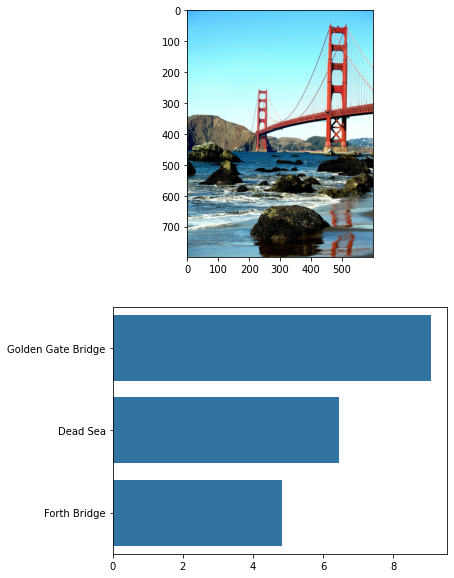

In [36]:
import seaborn as sns
def suggest_locations(img_path):
    # get landmark predictions
    path = img_path.split('/')
    print(f"Actual Label: {img_path.split('/')[2][3:].replace('_',' ')}")

    # get landmark predictions
    confidence, landmarks  = predict_landmarks(img_path, 3)

    print(f"Predicted Label: {landmarks[0]}")

    img = Image.open(img_path).convert('RGB')

    plt.figure(figsize = (6,10))

    ax = plt.subplot(2,1,1)
    ax.imshow(img)

    plt.subplot(2,1,2)
    sns.barplot(x=confidence, y=landmarks, color=sns.color_palette()[0]);
    plt.show()


# test on a sample image
suggest_locations('data/landmark_images/test/09.Golden_Gate_Bridge/1bc7a7f05288153b.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

I was expecting a higher accuracy than 70% on validation, more on the 75-80%. Especially after using ResNet50. However some possible points that could improve the performance are:

- More data to train on
- Different combinations of data augmentation
- Different Neural Net, e.g. VGG16

Predicted Label: Grand Canyon


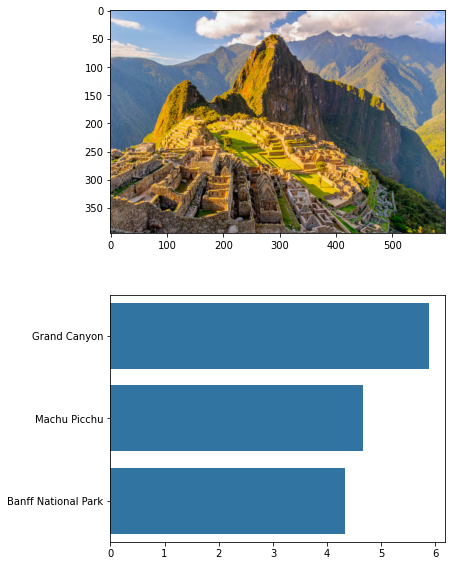

Filename: MachuPicchu.jpg
Predicted Label: Grand Canyon


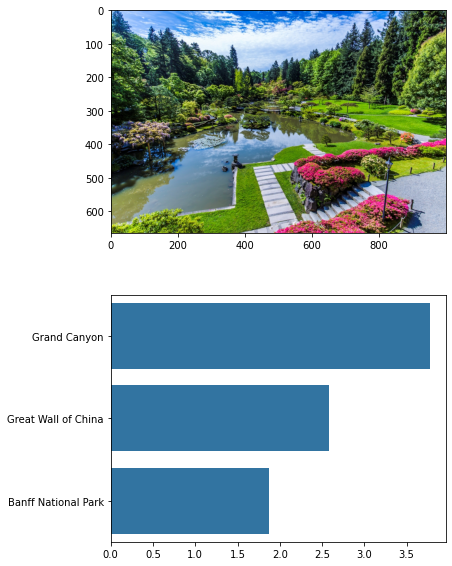

Filename: Seattle_Jap_Garden.jpg
Predicted Label: Stockholm City Hall


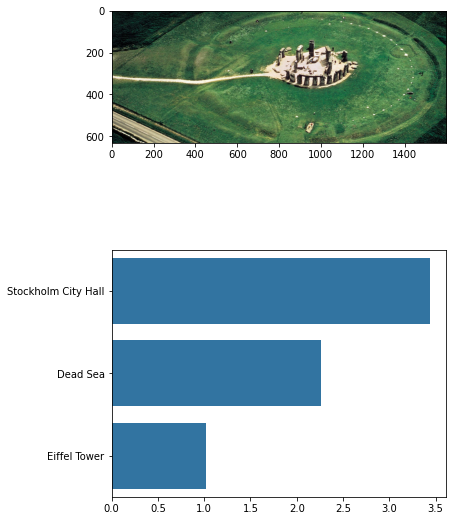

Filename: Stonehenge.jpg
Predicted Label: Death Valley National Park


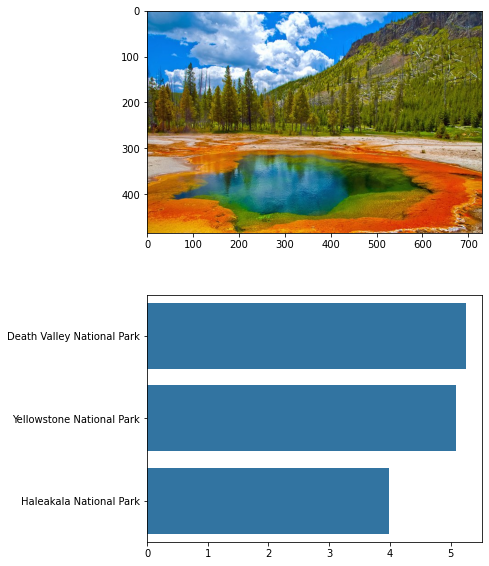

Filename: Yellowstone_National_Park.jpg


In [37]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

test_pics_location = os.path.join(data_location, 'LastPart_Test')
for file in os.listdir(test_pics_location.replace('/data', 'data')):
    suggest_locations(os.path.join(test_pics_location.replace('/data', 'data'), file))
    print(f'Filename: {file}')

